# CZ4045 : NLP - Text Classification using CNN

## Importing

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers, layers, losses, preprocessing
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pydot

In [3]:
#getting the version of tf
print(tf.__version__)

2.9.2


Checking GPU

In [4]:
if tf.test.gpu_device_name():
  print("Default GPU Device: {}".format(tf.test.gpu_device_name()))
else:
  print('Please install GPU version of TF')

Default GPU Device: /device:GPU:0


## Pre-processing

In [5]:
#remove url if present
def remove_url(text):
  url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
  return url_pattern.sub(r'', text)

#remove punctuations
def clean_text(text):
  delete_dict = {sp_character: '' for sp_character in string.punctuation} 
  delete_dict[' '] = ' ' 
  table = str.maketrans(delete_dict)
  text1 = text.translate(table)
  
  textArr= text1.split()
  text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
  
  return text2.lower()

In [10]:
dataset = pd.read_csv('nlp_datasets.csv')
dataset.head()

,Text,Sentiment
0,weaknesses are minor : the feel and layout of ...,NEGATIVE
1,many of our disney movies do n 't play on this...,NEGATIVE
2,player has a problem with dual-layer dvd 's su...,NEGATIVE
3,"i know the saying is "" you get what you pay fo...",NEGATIVE
4,will never purchase apex again .,NEGATIVE


In [13]:
print(dataset['Sentiment'].value_counts())
print(f"Length of Dataset: {len(dataset)}")

POSITIVE    2405
NEGATIVE    1366
Name: Sentiment, dtype: int64
Length of Dataset: 3771


In [14]:
dataset['Text'] = dataset['Text'].apply(clean_text)
dataset.head()

,Text,Sentiment
0,weaknesses are minor the feel and layout the r...,NEGATIVE
1,many our disney movies play this dvd player,NEGATIVE
2,player has problem with duallayer dvd such ali...,NEGATIVE
3,know the saying you get what you pay for but t...,NEGATIVE
4,will never purchase apex again,NEGATIVE


## Tokenization

In [16]:
#Splitting the dataset into (train+val), test
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(dataset['Text'].tolist())

#text to sequences - example: 'xyz' is out of vocab word therefore index = 1
print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

[[1, 132, 12, 7]]


## Splitting the Training Set into the different Splits

In [17]:
#Prior to splitting
print(f"Length of dataset: {len(dataset)}")
print(f"Length of Train: {int(0.8 * len(dataset))}")
print(f"Length of Valid: {int(0.1 * len(dataset))}")
print(f"Length of Test: {int(0.1 * len(dataset))}")

Length of dataset: 3771
Length of Train: 3016
Length of Valid: 377
Length of Test: 377


In [18]:
X_temp, X_test, y_temp, y_test = train_test_split(dataset['Text'].tolist(), 
                                                  dataset['Sentiment'].tolist(), 
                                                  test_size=0.1, stratify=dataset['Sentiment'].tolist(),
                                                  random_state=0)

In [28]:
#Joining the temp data enable splitting again into validation and training sets
x_temp_df = pd.DataFrame(X_temp, columns=['Text'])
y_temp_df = pd.DataFrame(y_temp, columns=['Sentiment'])
temp = pd.concat([x_temp_df,y_temp_df], axis=1)
#temp.rename(columns={'0':'Text', '1':'Sentiment'}, inplace=True)
temp.head()

,Text,Sentiment
0,that said disappointed the plunging mechanism,NEGATIVE
1,the way use the norton corporate work with abs...,POSITIVE
2,each battery lasts about hours,POSITIVE
3,joy stick for eazy navigation 35mb memory card...,POSITIVE
4,the player looked good right out the box offer...,POSITIVE


In [31]:
len(temp)

3393

In [38]:
#splitting into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(temp['Text'].tolist(), 
                                                  temp['Sentiment'].tolist(), 
                                                  test_size=0.111, stratify=temp['Sentiment'].tolist(),
                                                  random_state=0)

In [39]:
print(f"X_train : {len(X_train)}")
print(f"X_valid : {len(X_valid)}")
print(f"X_test : {len(X_test)}")

X_train : 3016
X_valid : 377
X_test : 378


In [40]:
#getting the class distribution
print("Class Distributions:")
print(f"Train: {str(Counter(y_train))}")
print(f"Valid: {str(Counter(y_valid))}")
print(f"Test: {str(Counter(y_test))}")

Class Distributions:
Train: Counter({'POSITIVE': 1924, 'NEGATIVE': 1092})
Valid: Counter({'POSITIVE': 240, 'NEGATIVE': 137})
Test: Counter({'POSITIVE': 241, 'NEGATIVE': 137})


From this, we can see that across the validation and the test set the classes are more or less evenly balanced out. Therefore, its a good representation.

## Converting Texts to Sequences and storing them as Arrays

In [42]:
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test) )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify

In [54]:
#finding the longest word sequence
train_num_words_text = pd.DataFrame(X_train, columns=['Text'])['Text'].apply(lambda x:len(str(x).split()))
max_len_train = max(train_num_words_text)

valid_num_words_text = pd.DataFrame(X_valid, columns=['Text'])['Text'].apply(lambda x:len(str(x).split()))
max_len_valid = max(valid_num_words_text)

test_num_words_text = pd.DataFrame(X_test, columns=['Text'])['Text'].apply(lambda x:len(str(x).split()))
max_len_test = max(test_num_words_text)

print('Longest Sentence in terms of words in Train: ', max_len_train)
print('Longest Sentence in terms of words in Valid: ', max_len_valid)
print('Longest Sentence in terms of words in Test: ', max_len_test)

Longest Sentence in terms of words in Train:  81
Longest Sentence in terms of words in Valid:  57
Longest Sentence in terms of words in Test:  51


## Padding the Sentence

Given that we keep the max length of padding as 85.

If we have a sentence of 10 words, then it will have the word indices for those 10 words and 0 for the remaining 75 elements. Eg: [  59,   47,  170, ...,    0,    0,    0]

In [55]:
x_train = pad_sequences(x_train, padding='post', maxlen=85)
x_valid = pad_sequences(x_valid, padding='post', maxlen=85)
x_test = pad_sequences(x_test, padding='post', maxlen=85)

## LabelEncoder

To convert the labels in a categorical form ie [0,1], where 0 - Negative, 1 - Positive.

In [57]:
#instantiating the LabelEncoder
le = LabelEncoder()

In [58]:
train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))

In [59]:
train_labels

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [62]:
list(le.classes_)

['NEGATIVE', 'POSITIVE']

This is the order in which the labels were converted to categorical form. Refer to this if mapping is needed.

## Creating Tensorflow Datasets

This is done by concatenating the sequences and their respective labels.

In [63]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

## Transforming the Labels

In [73]:
print(f"Train Dataset - Prior to Transforming Labels: \n{y_train[:10]}")
train_labels = le.fit_transform(y_train)

print("")

print("Text to Number")
print(train_labels[:10])
train_labels = np.asarray(tf.keras.utils.to_categorical(train_labels))

print("")

print("Number to Category")
print(list(le.classes_))
print(train_labels[:10])

Train Dataset - Prior to Transforming Labels: 
['POSITIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'NEGATIVE']

Text to Number
[1 0 1 1 0 0 1 1 1 0]

Number to Category
['NEGATIVE', 'POSITIVE']
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


## Observing the Newly Created Dataset

In [74]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==3:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==3:
        break
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==3:
        break  

======Train dataset ====
tf.Tensor(
[  59   47  170    3   19 1846 1483 1578 2660    3 5046  122 1059    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0], shape=(85,), dtype=int32) tf.Tensor([0. 1.], shape=(2,), dtype=float32)
tf.Tensor(
[   2  160  210 3253   71   97    2 1481    3  905  617 3254 3255 3256
 2223   51  160  355    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0], shape=(85,), 

## CNN Model Creation

In [163]:
max_features = 20000
sequence_length = 85
embedding_dim = 64

#Creating an Embedding layer - convert every index value to an embedding, every index is represented by 64 dimensional vector
model = tf.keras.Sequential()

#First Layer - Embedding Layer tats takes in input of 85 dimensional (sequence length) and for each word/index present it creates a 64 dimensional embedding
model.add(tf.keras.layers.Embedding(max_features+1, embedding_dim, input_length=sequence_length,
                                    embeddings_regularizer=regularizers.l2(0.0005)))

#Second Layer - Added 1D Conv Layer
model.add(tf.keras.layers.Conv1D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(0.0005),
                                 bias_regularizer=regularizers.l2(0.0005)))

#Third Layer - GlobalMaxPooling Layer
model.add(tf.keras.layers.MaxPooling1D())

#Fourth Layer - Dropout Layer [To address Overfitting]
model.add(tf.keras.layers.Dropout(0.5))

#Second Layer - Added 1D Conv Layer
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu', kernel_regularizer=regularizers.l2(0.0005),
                                 bias_regularizer=regularizers.l2(0.0005)))

#Third Layer - GlobalMaxPooling Layer
model.add(tf.keras.layers.MaxPooling1D())

#Fourth Layer - Dropout Layer [To address Overfitting]
model.add(tf.keras.layers.Dropout(0.5))

#Second Layer - Added 1D Conv Layer
model.add(tf.keras.layers.Conv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.0005),
                                 bias_regularizer=regularizers.l2(0.0005)))

#Third Layer - GlobalMaxPooling Layer
model.add(tf.keras.layers.MaxPooling1D())

#Fourth Layer - Dropout Layer [To address Overfitting]
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())

#Fifth Layer [Final Layer] - Output Layer -> has 2 neurons as we have only 2 classes
model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                                bias_regularizer=regularizers.l2(0.001)))

#Fifth Layer [Final Layer] - Output Layer -> has 2 neurons as we have only 2 classes
model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001),
                                bias_regularizer=regularizers.l2(0.001)))

#Fifth Layer [Final Layer] - Output Layer -> has 2 neurons as we have only 2 classes
model.add(tf.keras.layers.Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.001),
                                bias_regularizer=regularizers.l2(0.001)))

#Printing the Model Summary
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 85, 64)            1280064   
                                                                 
 conv1d_60 (Conv1D)          (None, 83, 128)           24704     
                                                                 
 max_pooling1d_53 (MaxPoolin  (None, 41, 128)          0         
 g1D)                                                            
                                                                 
 dropout_58 (Dropout)        (None, 41, 128)           0         
                                                                 
 conv1d_61 (Conv1D)          (None, 39, 64)            24640     
                                                                 
 max_pooling1d_54 (MaxPoolin  (None, 19, 64)           0         
 g1D)                                                

In [164]:
#callbacks - early stopping and storing best model checkpoint 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy", patience=10)
checkpoint_filepath = '/content/drive/MyDrive/Colab_Notebooks/NLP_train_on_crawled/weights/best_epoch{epoch}.hdf5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor = 'val_categorical_accuracy',
    save_best_only=True)

In [165]:
#from_logits = True --> so basically what it means is if softmax layer is not being added at the last layer then we 
#need to have the from_logits=True to indicate the probabilities are not normalized
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', 
              metrics=["CategoricalAccuracy"])

In [167]:
epochs = 100
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(64),
                    epochs=epochs ,
                    validation_data=valid_ds.batch(64),
                    verbose=1, 
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
48/48 [==============================] - 0s 9ms/step - loss: 0.1390 - categorical_accuracy: 0.9867 - val_loss: 1.4516 - val_categorical_accuracy: 0.7480
Epoch 2/100
48/48 [==============================] - 0s 8ms/step - loss: 0.1480 - categorical_accuracy: 0.9821 - val_loss: 1.3358 - val_categorical_accuracy: 0.7507
Epoch 3/100
48/48 [==============================] - 0s 8ms/step - loss: 0.1457 - categorical_accuracy: 0.9847 - val_loss: 1.2919 - val_categorical_accuracy: 0.7454
Epoch 4/100
48/48 [==============================] - 0s 8ms/step - loss: 0.1361 - categorical_accuracy: 0.9871 - val_loss: 1.3858 - val_categorical_accuracy: 0.7294
Epoch 5/100
48/48 [==============================] - 0s 8ms/step - loss: 0.1231 - categorical_accuracy: 0.9914 - val_loss: 1.4351 - val_categorical_accuracy: 0.7480
Epoch 6/100
48/48 [==============================] - 0s 8ms/step - loss: 0.1336 - categorical_accuracy: 0.9894 - val_loss: 1.5938 - val_categorical_accuracy: 0.6790
Epoch 7/10

## Saving Model and other Artifacts

In [184]:
model.save('/content/drive/MyDrive/Colab_Notebooks/NLP_train_on_crawled/weights/model.hdf5')
json_string = tokenizer.to_json()

In [185]:
import json
with open('/content/drive/MyDrive/Colab_Notebooks/NLP_train_on_crawled/weights/tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)

In [187]:
with open('/content/drive/MyDrive/Colab_Notebooks/NLP_train_on_crawled/weights/history.txt', 'w') as outfile:
    outfile.write(str(history.history))

## Plotting Loss and Accuracy Curves

### Loss Curves

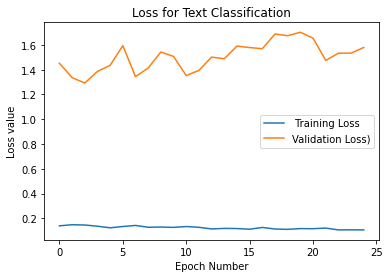

In [182]:
plt.plot(history.history['loss'], label=' Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('Epoch Number')
plt.legend(loc="center right")
plt.show()

### Accuracy Curves

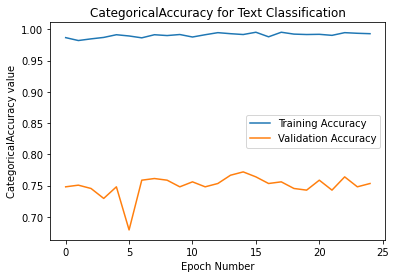

In [183]:
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('Epoch Number')
plt.legend(loc="center right")
plt.show()

In [189]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)

Generate predictions for all samples
12/12 [==============================] - 0s 13ms/step
[[1.96150475e-04 9.99803841e-01]
 [3.76197988e-07 9.99999642e-01]
 [9.99974966e-01 2.50090543e-05]
 [9.99073505e-01 9.26514156e-04]
 [3.04931425e-03 9.96950626e-01]
 [9.55589592e-01 4.44103815e-02]
 [9.67991946e-06 9.99990344e-01]
 [9.90918875e-01 9.08110198e-03]
 [8.98067296e-01 1.01932637e-01]
 [4.50758787e-04 9.99549210e-01]
 [9.95639443e-01 4.36057243e-03]
 [9.99337852e-01 6.62103354e-04]
 [2.35828268e-03 9.97641802e-01]
 [4.12339780e-11 1.00000000e+00]
 [1.79478811e-05 9.99981999e-01]
 [8.80651414e-01 1.19348563e-01]
 [9.99999404e-01 6.17264334e-07]
 [7.80686855e-01 2.19313174e-01]
 [5.42554855e-01 4.57445085e-01]
 [3.18032164e-07 9.99999642e-01]
 [5.65612549e-03 9.94343877e-01]
 [9.93312299e-01 6.68765046e-03]
 [3.31669810e-07 9.99999642e-01]
 [9.96951938e-01 3.04805953e-03]
 [9.69750643e-01 3.02493628e-02]
 [9.86910522e-01 1.30894668e-02]
 [9.96235907e-01 3.76414391e-03]
 [3.64547654e-04 9

In [218]:
x_test_copy = x_test
x_test_copy = pd.DataFrame(x_test_copy)

In [236]:
x_test_copy['pred_sentiment']= predict_results

x_test_copy['pred_sentiment'] = np.where((x_test_copy.pred_sentiment == '0'),'NEGATIVE',x_test_copy.pred_sentiment)
x_test_copy['pred_sentiment'] = np.where((x_test_copy.pred_sentiment == '1'),'POSITIVE',x_test_copy.pred_sentiment)

In [237]:
x_test_copy

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,pred_sentiment
0,143,24,101,6,2,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,POSITIVE
1,4,22,303,3,4478,5,1563,5,414,1939,350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,POSITIVE
2,10,34,87,463,9,74,35,1624,790,2,103,49,942,10,2,87,77,312,3,1042,2,103,2825,222,61,1607,135,2826,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,15,106,2149,79,2,36,213,38,3,9,666,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10,40,1247,163,4,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,2,55,312,120,449,3,1940,911,41,244,44,1344,29,2,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,POSITIVE
374,2,36,15,22,131,7,9,4211,221,1934,213,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,POSITIVE
375,7,114,259,56,33,33,33,84,59,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,POSITIVE
376,79,4,495,3,40,11,163,4,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,POSITIVE


In [238]:
acc_count = 0
wrong_ans_count = 0

for i in range(len(y_test)):
  if y_test[i] == x_test_copy['pred_sentiment'][i]:
    acc_count += 1
  else:
    wrong_ans_count += 1

print("Accuracy on Test:")
print(f"Correct: {acc_count}/{len(y_test)}")
print(f"Wrong: {wrong_ans_count}/{len(y_test)}")
print(f"Total Accuracy: {(acc_count/len(y_test))*100}%")

Accuracy on Test:
Correct: 188/378
Wrong: 190/378
Total Accuracy: 49.735449735449734%
